# Práctica Bloque 2 - IA

Autores: Sergi Mayol Matos, Alejandro Rodríguez Arguimbau <br>
Correos: sergi.mayol1@estudiant.uib.cat, alejandro.rodriguez7@estudiant.uib.cat <br>
Fecha: 06/12/2022

## Prerrequisitos

Para los siguientes apartados ([parte 1](#parte-1-preparación-de-los-datos) y [parte 2]()) se emplearán las siguientes librerías:

* [numpy](https://numpy.org/)
* [pandas](https://pandas.pydata.org/)
* [matplotlib](https://matplotlib.org/)
* [sklearn](https://scikit-learn.org/stable/)

> Nota: Para ver más información sobre las librerías, mirar el fichero [Pipfile](./Pipfile).

### Instalación de librerías

Para instalar las librerías, se debe ejecutar el siguiente comando:

```bash
pipenv install -d
```

> Nota: Se necesita tener instalado [pipenv](https://pypi.org/project/pipenv/).

### Importación de librerías

In [756]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Parte 1: Entrenamiento de modelos y comparación de resultados 

En la primera parte de la práctica se entrenarán diferentes modelos de clasificación (Regrsión lineal, Perceptrón, Random Forest) y se compararán sus resultados.

### Carga de datos

In [757]:
df = pd.read_csv("./datos/dades.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Análisis y procesamiento de datos

En esta sección se analizarán los datos de entrada para ver si hay que eliminar o modificar algún dato.

Para analizar los datos, comprobaremos la cantidad de datos que faltan en cada columna.

In [758]:
def check_is_nan(df: pd.DataFrame):
    results = []
    col_names = []
    for col in df.columns:
        col_names.append(col)
        results.append(df[col].isna().sum())

    return {"col_names": col_names, "results": results, "percent": [x/len(df) for x in results]}


results = check_is_nan(df)

for i in range(len(results["col_names"])):
    print(
        f"{results['col_names'][i]}: {results['results'][i]} ({results['percent'][i]})")

PassengerId: 0 (0.0)
Survived: 0 (0.0)
Pclass: 0 (0.0)
Name: 0 (0.0)
Sex: 0 (0.0)
Age: 177 (0.19865319865319866)
SibSp: 0 (0.0)
Parch: 0 (0.0)
Ticket: 0 (0.0)
Fare: 0 (0.0)
Cabin: 687 (0.7710437710437711)
Embarked: 2 (0.002244668911335578)


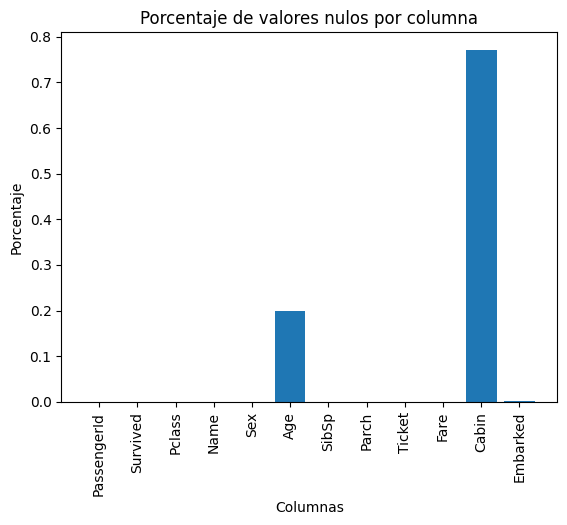

In [759]:
plt.bar(results["col_names"], results["percent"])
plt.title("Porcentaje de valores nulos por columna")
plt.xlabel("Columnas")
plt.ylabel("Porcentaje")
plt.xticks(rotation=90)
plt.show()

Se puede observar que existen 3 columnas con datos inexistentes:

* `Age`
* `Cabin`
* `Embarked`

Aunque de las 3 columnas, la columna con más datos faltantes, con diferencia, es `Cabin`, casi un 80%. Por ello, se eliminará esta columna.

Por lo que los datos que quedan, de momento, son:

In [760]:
df.drop(['Cabin'], axis=1, inplace=True)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Para las columnas `Age` y `Embarked`, se rellenarán los datos faltantes con la media y la moda, respectivamente. Se realizará la media de `Age`, ya que faltan aproximadamente un **20%** de los datos, y la moda de `Embarked`, ya que faltan muy pocos datos y no son datos numéricos.

In [761]:
media_edad = df["Age"].mean()
df["Age"].fillna(media_edad, inplace=True)

moda_embarque = df["Embarked"].mode()[0]
df["Embarked"].fillna(moda_embarque, inplace=True)

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


Para la columna de `Sex`, se crearán 2 columnas nuevas, `Sex_male` y `Sex_female`, que serán 1 si el pasajero es hombre o mujer, respectivamente, y 0 en caso contrario.

In [762]:
clb = df.pop("Sex")
ohe_clb = pd.get_dummies(clb, prefix='Sex')
df = pd.concat([df.reset_index(drop=True), ohe_clb.reset_index(drop=True)], axis=1, sort=False)
df.head()


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,S,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,S,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,0,1


Obtenemos el tamaño de cada familia y la añadimos al conjunto de datos. Además, se convierte la columna de Embarked en numérica.

In [763]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
# One-hot encoding para la columna Embarked
clb = df.pop("Embarked")
ohe_clb = pd.get_dummies(clb, prefix='Embarked')
df = pd.concat([df.reset_index(drop=True), ohe_clb.reset_index(drop=True)], axis=1, sort=False)
df.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex_female,Sex_male,FamilySize,Embarked_C,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,1,2,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,1,0,2,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,1,0,1,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,1,0,2,0,0,1
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,1,1,0,0,1


Se puede dividir la columna `Age` en 5 grupos:
* 0-12  $\rightarrow$ Niños
* 13-17 $\rightarrow$ Adolescentes
* 18-45 $\rightarrow$ Adultos
* 46-64 $\rightarrow$ Adultos mayores
* 65+   $\rightarrow$ Ancianos

Y la columna `Fare` en 4 grupos:
* 0-7.91   $\rightarrow$ Bajo
* 7.91-14.45 $\rightarrow$ Medio
* 14.45-31 $\rightarrow$ Alto
* 31+      $\rightarrow$ Muy alto

In [764]:
for age in df:
    df['Age_type'] = pd.cut(df['Age'], bins=[0, 13, 18, 45, 65, 120], labels=['Child', 'Teenager', 'Adult', 'Senior', 'Elderly'])

for fare in df:
    df['Fare_type'] = pd.cut(df['Fare'], bins=[0, 7.91, 14.454, 31, 120], labels=['Low_fare', 'median_fare', 'high_fare', 'very_high_fare'])

df.drop(['Age'], axis=1, inplace=True)
df.drop(['Fare'], axis=1, inplace=True)

df.head()

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Sex_female,Sex_male,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Age_type,Fare_type
0,1,0,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,0,1,2,0,0,1,Adult,Low_fare
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,1,0,2,1,0,0,Adult,very_high_fare
2,3,1,3,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,1,0,1,0,0,1,Adult,median_fare
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,1,0,2,0,0,1,Adult,very_high_fare
4,5,0,3,"Allen, Mr. William Henry",0,0,373450,0,1,1,0,0,1,Adult,median_fare


In [765]:
# One-hot encoding para la columna Age_type 
clb = df.pop("Age_type")
ohe_clb = pd.get_dummies(clb, prefix='Age')
df = pd.concat([df.reset_index(drop=True), ohe_clb.reset_index(drop=True)], axis=1, sort=False)

# One-hot encoding para la columna Fare_type
clb = df.pop("Fare_type")
ohe_clb = pd.get_dummies(clb, prefix='Fare')
df = pd.concat([df.reset_index(drop=True), ohe_clb.reset_index(drop=True)], axis=1, sort=False)

df.head()

,PassengerId,Survived,Pclass,Name,SibSp,Parch,Ticket,Sex_female,Sex_male,FamilySize,...,Embarked_S,Age_Child,Age_Teenager,Age_Adult,Age_Senior,Age_Elderly,Fare_Low_fare,Fare_median_fare,Fare_high_fare,Fare_very_high_fare
0,1,0,3,"Braund, Mr. Owen Harris",1,0,A/5 21171,0,1,2,...,1,0,0,1,0,0,1,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0,PC 17599,1,0,2,...,0,0,0,1,0,0,0,0,0,1
2,3,1,3,"Heikkinen, Miss. Laina",0,0,STON/O2. 3101282,1,0,1,...,1,0,0,1,0,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0,113803,1,0,2,...,1,0,0,1,0,0,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",0,0,373450,0,1,1,...,1,0,0,1,0,0,0,1,0,0


Se realiza la matriz de correlación

In [766]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')


,PassengerId,Survived,Pclass,SibSp,Parch,Sex_female,Sex_male,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Age_Child,Age_Teenager,Age_Adult,Age_Senior,Age_Elderly,Fare_Low_fare,Fare_median_fare,Fare_high_fare,Fare_very_high_fare
PassengerId,1.000000,-0.005007,-0.035144,-0.057527,-0.001652,-0.042939,0.042939,-0.040143,-0.001205,-0.033606,0.022204,-0.009668,0.008710,-0.027175,0.039078,0.003516,0.031688,-0.013074,-0.037395,0.013862
Survived,-0.005007,1.000000,-0.338481,-0.035322,0.081629,0.543351,-0.543351,0.016639,0.168240,0.003650,-0.149683,0.125678,0.016506,-0.078405,0.004003,-0.050661,-0.200973,-0.087603,0.074470,0.173164
Pclass,-0.035144,-0.338481,1.000000,0.083081,0.018443,-0.131900,0.131900,0.065997,-0.243292,0.221009,0.074053,0.114504,0.060768,0.122878,-0.310384,-0.063635,0.450238,0.200349,-0.042044,-0.453875
SibSp,-0.057527,-0.035322,0.083081,1.000000,0.414838,0.114631,-0.114631,0.890712,-0.059528,-0.026354,0.068734,0.345454,0.040025,-0.184149,-0.061654,-0.034374,-0.232991,-0.202833,0.121717,0.336510
Parch,-0.001652,0.081629,0.018443,0.414838,1.000000,0.245489,-0.245489,0.783111,-0.011069,-0.081228,0.060814,0.364779,0.031754,-0.205642,-0.041761,-0.030317,-0.244930,-0.203853,0.161366,0.253944
Sex_female,-0.042939,0.543351,-0.131900,0.114631,0.245489,1.000000,-1.000000,0.200988,0.082853,0.074115,-0.119224,0.077893,0.088803,-0.067166,-0.026484,-0.070217,-0.168288,-0.079221,0.092995,0.116980
Sex_male,0.042939,-0.543351,0.131900,-0.114631,-0.245489,-1.000000,1.000000,-0.200988,-0.082853,-0.074115,0.119224,-0.077893,-0.088803,0.067166,0.026484,0.070217,0.168288,0.079221,-0.092995,-0.116980
FamilySize,-0.040143,0.016639,0.065997,0.890712,0.783111,0.200988,-0.200988,1.000000,-0.046215,-0.058592,0.077359,0.418344,0.043219,-0.228595,-0.063001,-0.038639,-0.281604,-0.240471,0.163805,0.356859
Embarked_C,-0.001205,0.168240,-0.243292,-0.059528,-0.011069,0.082853,-0.082853,-0.046215,1.000000,-0.148258,-0.782742,-0.014698,0.034349,-0.053997,0.056595,0.014953,-0.035399,-0.199984,0.038225,0.151024
Embarked_Q,-0.033606,0.003650,0.221009,-0.026354,-0.081228,0.074115,-0.074115,-0.058592,-0.148258,1.000000,-0.499421,-0.031503,-0.028231,0.089027,-0.080368,0.013069,0.311829,-0.118679,-0.016363,-0.137169


Se puede observar que las columna `Survived` tiene una correlación más alto con `Sex_female` y `Sex_male`, la diferencia es que `Sex_female` es positiva y `Sex_male` es negativa. Es decir, que si aumenta el número de supervivientes, aumenta el número de mujeres y disminuye el número de hombres. 

A parte de las columnas mencionadas anteriormente, el resto de columnas no tienen una correlación muy alta entre ellas, por lo que no se eliminarán ninguna columna. Lo que, sii que se eliminarán las siguiente columnas, ya que no aportan información relevante:
* `PassengerId`
* `Name`
* `Ticket`
* `Embarked_C`
* `Embarked_Q`
* `Embarked_S`

In [767]:
df.drop(['PassengerId'], axis=1, inplace=True)
df.drop(['Name'], axis=1, inplace=True)
df.drop(['Ticket'], axis=1, inplace=True)
# Las columnas de embarque no aportan nada a la predicción, por lo que las eliminamos
df.drop(['Embarked_C'], axis=1, inplace=True)
df.drop(['Embarked_Q'], axis=1, inplace=True)
df.drop(['Embarked_S'], axis=1, inplace=True)


A continuación, se muestra la distribución de los datos de cada columna:

In [768]:
"""
g = sns.pairplot(data=df, hue='Survived', palette='husl',
                 size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])
"""

"\ng = sns.pairplot(data=df, hue='Survived', palette='husl',\n                 size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))\ng.set(xticklabels=[])\n"

### Entrenamiento de modelos

In [769]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, mean_absolute_error, mean_squared_error,
                             classification_report)

training_ds = df.drop(['Survived'], axis=1)
target_ds = df['Survived']

# Dividimos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(
    training_ds, target_ds, test_size=0.33, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((596, 15), (295, 15), (596,), (295,))

#### Regresión logística

Entrenamiento y precisión del modelo:

In [770]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()

logisticRegr.fit(X_train, y_train)

log_y_pred = logisticRegr.predict(X_test)

print("Classification report: \n", classification_report(y_test, log_y_pred))


Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       175
           1       0.81      0.73      0.77       120

    accuracy                           0.82       295
   macro avg       0.82      0.81      0.81       295
weighted avg       0.82      0.82      0.82       295



Se observa que el modelo tiene una precisión de media del $\approx$ 82%.

<AxesSubplot:>

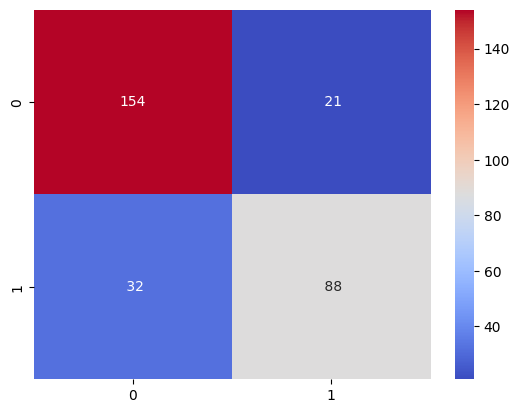

In [771]:
# Matriz de confusión
sns.heatmap(confusion_matrix(y_test, log_y_pred),
            annot=True, fmt="3.0f", cmap='coolwarm')

Podemos observar que ...

#### Perceptrón

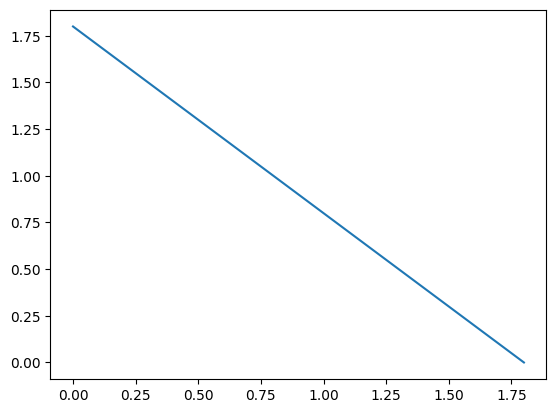

In [772]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(tol=1e-3, random_state=42)

perceptron.fit(X_train, y_train)

#x_intercept = -perceptron.intercept_[0] / perceptron.coef_[0][0]
x_intercept = (0, -perceptron.intercept_[0] / perceptron.coef_[0][0])
y_intercept = (-perceptron.intercept_[0] / perceptron.coef_[0][0], 0)

plt.plot(x_intercept, y_intercept)

In [773]:
percep_y_pred = perceptron.predict(X_test)

print("Classification report: \n", classification_report(y_test, percep_y_pred))


Classification report: 
               precision    recall  f1-score   support

           0       0.74      0.93      0.82       175
           1       0.83      0.53      0.65       120

    accuracy                           0.77       295
   macro avg       0.79      0.73      0.74       295
weighted avg       0.78      0.77      0.75       295



<AxesSubplot:>

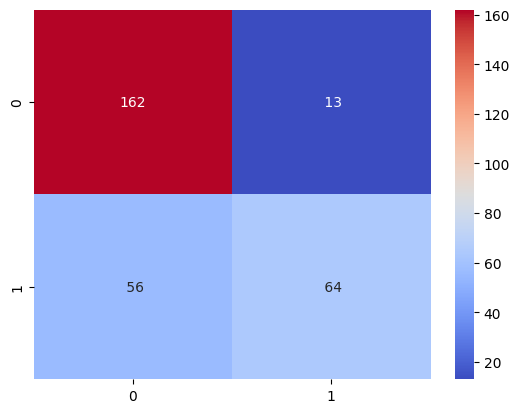

In [774]:
sns.heatmap(confusion_matrix(y_test, percep_y_pred),
            annot=True, fmt="3.0f", cmap='coolwarm')

#### Árbol de decisión - Random Forest

Entrenamiento y precisión del modelo:

In [779]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(bootstrap=True, max_depth=90, min_samples_leaf=3,
                            min_samples_split=8, n_estimators=200)

rf.fit(X_train, y_train)

rf_y_pred = rf.predict(X_test)

print("Classification report: \n", classification_report(y_test, rf_y_pred))


Classification report: 
               precision    recall  f1-score   support

           0       0.82      0.92      0.87       175
           1       0.86      0.71      0.78       120

    accuracy                           0.83       295
   macro avg       0.84      0.81      0.82       295
weighted avg       0.84      0.83      0.83       295



Se observa que el modelo tiene una precisión de media del $\approx$ 84%.

<AxesSubplot:>

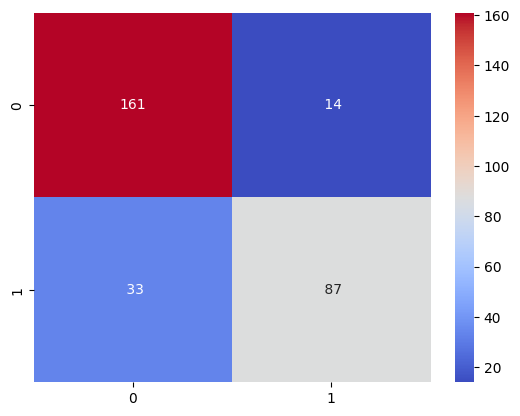

In [776]:
# Matriz de confusión
sns.heatmap(confusion_matrix(y_test, rf_y_pred),
            annot=True, fmt="3.0f", cmap='coolwarm')

### Evaluación y comparción de resultados

In [777]:
modelos = pd.DataFrame({
    'Modelo': ['Regresión Logística', 'Perceptrón', 'Random Forest'],
    'Score': [round(accuracy_score(y_test, log_y_pred), 2), round(accuracy_score(y_test, percep_y_pred), 2), round(accuracy_score(y_test, rf_y_pred), 2)],
    'Precision': [round(precision_score(y_test, log_y_pred), 2), round(precision_score(y_test, percep_y_pred), 2), round(precision_score(y_test, rf_y_pred), 2)],
    'Recall': [round(recall_score(y_test, log_y_pred), 2), round(recall_score(y_test, percep_y_pred), 2), round(recall_score(y_test, rf_y_pred), 2)],
    'F1': [round(f1_score(y_test, log_y_pred), 2), round(f1_score(y_test, percep_y_pred), 2), round(f1_score(y_test, rf_y_pred), 2)],
    'MAE': [round(mean_absolute_error(y_test, log_y_pred), 2), round(mean_absolute_error(y_test, percep_y_pred), 2), round(mean_absolute_error(y_test, rf_y_pred), 2)],
    'MSE': [round(mean_squared_error(y_test, log_y_pred), 2), round(mean_squared_error(y_test, percep_y_pred), 2), round(mean_squared_error(y_test, rf_y_pred), 2)]
})

modelos.sort_values(by='Score', ascending=False)

,Modelo,Score,Precision,Recall,F1,MAE,MSE
2,Random Forest,0.84,0.86,0.72,0.79,0.16,0.16
0,Regresión Logística,0.82,0.81,0.73,0.77,0.18,0.18
1,Perceptrón,0.77,0.83,0.53,0.65,0.23,0.23


Viendo los resultados el modelo con mayor acierto es el Random Forest, con una puntación media de $\approx$ 84%.

## Parte 2: Importancia y selección de características

El modelo se basará en características como el nombre de los pasajeros, el sexo o la edad. Para la realización de los modelos se ha hecho una selección de estas características.

La importancia de una característica viene determinada por el valor que esta proporciona al conjunto de datos. 

Por ejemplo: las columnas Name y Ticket no nos proporcionan ningún valor útil al conjunto de datos y por ello, se han eliminado y no se han tenido en cuenta. 

En este apartado, se analizará la importancia de cada una de las características para cada modelo de entrenamiento.

- Feature importance Random Forest
- Feature importance Regresión Lineal
- Feature importance Perceptron
- https://machinelearningmastery.com/calculate-feature-importance-with-python/

Para seleccionar los mejores parámetros del modelo Random Forest, se ha utilizado la función `GridSearchCV` de la librería `sklearn`. Esta función realiza una búsqueda exhaustiva de los mejores parámetros para el modelo.

In [778]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'max_depth': [80, 90, 100, 110],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 500, 700, 1000],
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_


Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'max_depth': 90,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

<AxesSubplot:>

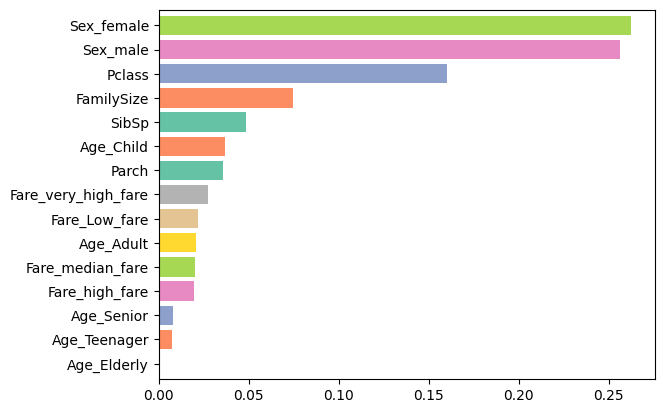

In [781]:
pd.Series(rf.feature_importances_, X_train.columns).sort_values(
    ascending=True).plot.barh(width=0.8, color=sns.color_palette('Set2', 10))
